# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from collections import defaultdict

# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [2]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [3]:
rentals = immo_data.copy()

In [4]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [5]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [6]:
rentals.shape

(268850, 49)

- We observe that the dataframe has 49 features associated with 268,850 apartment records that have been put up for rent. 
- We note that there are various price-related features that will be examined to determine the appropriate target feature. For instance, we need to choose between totalRent and baseRent. Furthermore, we neet to determin the relationships between such features as heatingCosts and the possible target features of totalRent and baseRent.
- The dataframe features comprise of 4 main datatypes, including 6 boolean, 18 float, 6 integer and 19 object datatypes. We would need to verfiy that these datatypes are accurate in the context of our goal of developing a price model for rent. We also note a varying level of quality associated with each feature in terms of how many records exist for the particular feature. We would need to deal with those features that have a lot of empty values. 
- Finally, we observe that the amount of memory used up by the dataframe is ~89, which is manageable. Higher capacity data-processing cloud computing technologies may not be necessary.

## 5. Reviewing the Data 

## Reviewing Missing Values

In [7]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['Count', '%age total']
missing.sort_values(by = 'Count', ascending = False)

,Count,%age total
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


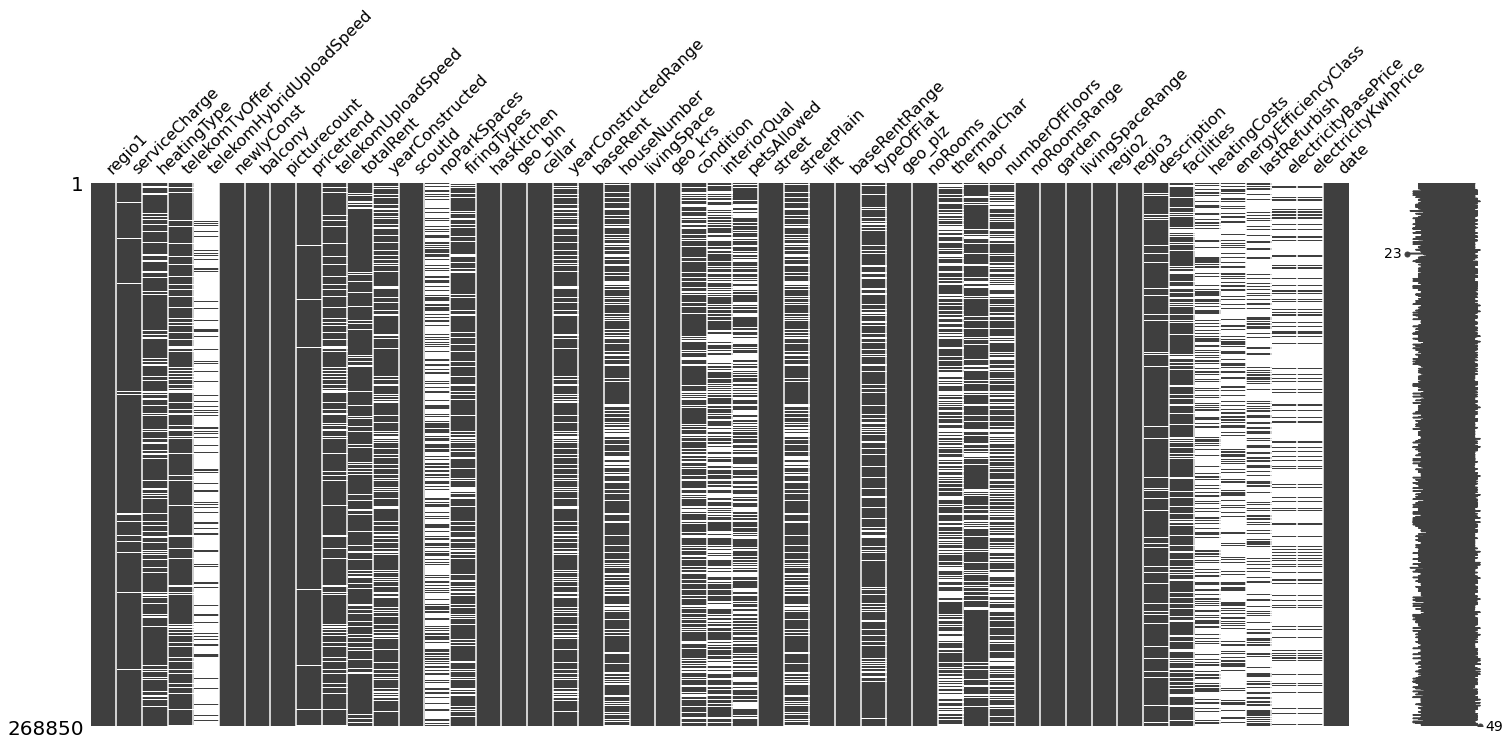

In [8]:
msno.matrix(rentals)

In [9]:
#Features with missing values
mssgCols = rentals.columns[rentals.isna().any()]

In [10]:
mssgNumeric = rentals[mssgCols].select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

In [11]:
mssgNumeric.head(2)

,serviceCharge,telekomHybridUploadSpeed,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,yearConstructedRange,thermalChar,floor,numberOfFloors,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,245.0,NaN,4.62,10.0,840.0,1965.0,1.0,2.0,181.4,1.0,3.0,NaN,NaN,NaN,NaN
1,134.0,NaN,3.47,10.0,NaN,1871.0,2.0,1.0,NaN,NaN,NaN,NaN,2019.0,NaN,NaN


In [12]:
mssgCat = rentals[mssgCols].select_dtypes('object')

In [13]:
mssgCat.head(2)

,heatingType,telekomTvOffer,firingTypes,houseNumber,condition,interiorQual,petsAllowed,streetPlain,typeOfFlat,description,facilities,energyEfficiencyClass
0,central_heating,ONE_YEAR_FREE,oil,244,well_kept,normal,NaN,Schüruferstraße,ground_floor,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN
1,self_contained_central_heating,ONE_YEAR_FREE,gas,NaN,refurbished,normal,no,NaN,ground_floor,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN


## Reviewing Categorical Features with Missing Values 

In [14]:
mssgCat.describe()

,heatingType,telekomTvOffer,firingTypes,houseNumber,condition,interiorQual,petsAllowed,streetPlain,typeOfFlat,description,facilities,energyEfficiencyClass
count,223994,236231,211886,197832,200361,156185,154277,197837,232236,249103,215926,77787
unique,13,3,132,5510,10,4,3,54490,10,212621,189526,10
top,central_heating,ONE_YEAR_FREE,gas,1,well_kept,normal,negotiable,Hauptstraße,apartment,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat,C
freq,128977,227632,110899,7173,66591,81826,91970,911,131522,216,207,14613


- First, we notice that firingTypes (132), houseNumber(5510), streetPlain(54490), description (212621) and facilities (189526) have a lot of categories. We can take a closer look at these. 

In [15]:
mssgCat[['firingTypes','houseNumber', 'streetPlain','description','facilities']].sample(20)

,firingTypes,houseNumber,streetPlain,description,facilities
74647,pellet_heating,9a,Holzstrasse,Diese 3er WG-Wohnung wurde erst im Jahr 2012 k...,Einbauküche (2012)\nZentralheizung Pellets (20...
105086,gas,13,Landeskronstraße,Zu vermieten ist per sofort eine 1 Raum Wohnun...,NaN
2892,oil,NaN,NaN,"Zum 01.0&.2019 können Sie diese attraktive, ge...",NaN
186986,gas,NaN,NaN,Gasheizungaus dem Jahr 1992,Wohnen in ruhiger Lage. Große Grünfläche am bz...
104385,district_heating,82,Heidenheimer_Str.,Gemütliches Zimmer in einem Studentenwohnheim ...,"- das Zimmer ist möbliert, u. a. mit Schreibti..."
235212,gas,18a,Adlzreiterstraße,Sehr schöne und hochwertige 4-Zimmer-Wohnung i...,Waschmaschine in der Wohnung\nFlachbildfernseh...
166906,gas,40,Luitpoldstraße,- Gäste-WC\n- Küche \n- Bad mit Badewanne und ...,NaN
137479,gas,58,Geibelstraße,"Im 1. OG eines Mehrfamilienhauses, befindet si...",- Balkon\r\n- neuer Bodenbelag\r\n- renoviert\...
166057,gas,92,Schützenstraße,Die helle Wohnung befindet sich im zweiten Obe...,NaN
148534,gas,98,Alt-Heiligensee,In einer repräsentativen Landhausvilla von 191...,In der gesamten Wohnung ist ein natürlicher Ko...


- houseNumber is the unit number of apartment, streetPlain is the street name, description describes the apartment, and facilities outline the features of the apartment. They are unlikely to make good categories for further analysis. Furthermore, the quantities are large. We will drop these. 
- firingTypes gives us a sense of the kind of fuel used in the apartment. heatingType gives us a similar indication of how the apartment is powered. We will drop this feature as well. 

In [16]:
#Drop houseNumber, streetPlain, description, facilities, firingTypes
mssgCat.drop(columns = ['houseNumber','streetPlain','description','facilities','firingTypes'], axis = 1, inplace = True)

In [17]:
mssgCat.describe()

,heatingType,telekomTvOffer,condition,interiorQual,petsAllowed,typeOfFlat,energyEfficiencyClass
count,223994,236231,200361,156185,154277,232236,77787
unique,13,3,10,4,3,10,10
top,central_heating,ONE_YEAR_FREE,well_kept,normal,negotiable,apartment,C
freq,128977,227632,66591,81826,91970,131522,14613


- To determine the most common category as a percentage of the total numbers of values. If this percentage is above 80% we may consider filling the missing values of the feature with this information 

In [18]:
def top_cat_perc(df,var):
    '''Takes a categorical dataframe and variable name to calculate the percentage of the most common category 
    for the variable'''
    total = 0
    col_dict = defaultdict(int)
    for k,v in df[var].value_counts().items():
        col_dict[k] = v
        total += v
    newdf = (pd.DataFrame(col_dict, index = ['%count']) * 100/total)
    return [newdf.columns[0],newdf.iloc[0,0]]   


In [19]:
def freq_table(cat_df):
    '''Takes a categorical dataframe and returns a dataframe showing  the top category for each variable and its percentage
    frequency'''
    portion = defaultdict(list)
    for element in cat_df.columns:
        portion[element] = top_cat_perc(cat_df, element)
    portiondf = pd.DataFrame(portion, index = ['topCat','%Freq'])
    return portiondf.T

In [20]:
freq_table(mssgCat)

,topCat,%Freq
heatingType,central_heating,57.5806
telekomTvOffer,ONE_YEAR_FREE,96.3599
condition,well_kept,33.2355
interiorQual,normal,52.3904
petsAllowed,negotiable,59.6136
typeOfFlat,apartment,56.6329
energyEfficiencyClass,C,18.7859


- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of the cases. We can probably use this for our missing values. But we should take a closer look at the categories of these features. 

In [21]:
#Create dictionary consisting of mssgCat vars and their unique values
dict([[i, mssgCat[i].unique()] for i in mssgCat])

{'heatingType': array(['central_heating', 'self_contained_central_heating',
        'floor_heating', 'district_heating', 'gas_heating', 'oil_heating',
        nan, 'wood_pellet_heating', 'electric_heating',
        'combined_heat_and_power_plant', 'heat_pump',
        'night_storage_heater', 'stove_heating', 'solar_heating'],
       dtype=object),
 'telekomTvOffer': array(['ONE_YEAR_FREE', nan, 'NONE', 'ON_DEMAND'], dtype=object),
 'condition': array(['well_kept', 'refurbished', 'first_time_use', nan,
        'fully_renovated', 'mint_condition',
        'first_time_use_after_refurbishment', 'modernized', 'negotiable',
        'need_of_renovation', 'ripe_for_demolition'], dtype=object),
 'interiorQual': array(['normal', 'sophisticated', nan, 'simple', 'luxury'], dtype=object),
 'petsAllowed': array([nan, 'no', 'negotiable', 'yes'], dtype=object),
 'typeOfFlat': array(['ground_floor', 'apartment', 'other', nan, 'roof_storey',
        'raised_ground_floor', 'terraced_flat', 'half_basement

### Reviewing Remaining Categorical Features with Missing Values 

- 'telekomTvOffer': Tells us if tv is included with rent. Previously determined that top category is ONE_YEAR_FREE at 96% and that 25% of its values missing. May consider replacing nan values with ONE_YEAR_FREE.

In [22]:
#Determine counts of telekomTvOffer categories
mssgCat.telekomTvOffer.value_counts()

ONE_YEAR_FREE    227632
NONE               4957
ON_DEMAND          3642
Name: telekomTvOffer, dtype: int64

- Even though telekomTvOffer has ONE_YEAR_FREE as its prominent category at over 96%, we recognize that this is an incentive. Incentives are typically advertized, so it is very likely that if a tv offer is not provided it is not available. Furthermore, 'ON_DEMAND' is not a definite tv offer and probably has to be negotiated as part of the rent. Also, its count is relatively low compared to ONE_YEAR_FREE. We will therefore replace all values of this feature that are not ONE_YEAR_FREE with 'NONE', including 'ON_DEMAND'.

In [23]:
#Select telekomTvOffer entries with value as ONE_YEAR_FREE 
rentals_telekom_ONE_YEAR_FREE = rentals.telekomTvOffer == 'ONE_YEAR_FREE'

In [24]:
#Replace values of telekomTvOffer that are not 'ONE_YEAR_FREE' with 'NONE'
rentals.telekomTvOffer[~rentals_telekom_ONE_YEAR_FREE] = 'NONE'

<ipython-input-24-eff79fb09a13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals.telekomTvOffer[~rentals_telekom_ONE_YEAR_FREE] = 'NONE'


In [25]:
#Verify that telekomTvOffer only has no nan
rentals.telekomTvOffer.isna().sum()

0

- 'petsAllowed': Indicates if pets are allowed in apartment. Previously determined that top category is 'negotiable' at 60% and over 42% of its values  are missing. 

In [26]:
#Review counts of petsAllowed categories
mssgCat.petsAllowed.value_counts()

negotiable    91970
no            51991
yes           10316
Name: petsAllowed, dtype: int64

- Similar to telekomTvOffer, this feature is an incentive that is typically advertized. It is likely that if the feature is not specified then we can assume pets are not encouraged. We will fill missing values with no.

In [27]:
#Select petsAllowed entries that are nan and replace them with no
rentals.petsAllowed[rentals.petsAllowed.isna()] = 'no'

<ipython-input-27-a353414ae8a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals.petsAllowed[rentals.petsAllowed.isna()] = 'no'


In [28]:
#Verify that petsAllowed has no nan entries
rentals.petsAllowed.isna().sum()

0

- 'condition': Indicates appearance of apartment. Previously determined top category as 'well_kept' at 33% and over 25% of its values are missing.

In [29]:
#Review counts of condition categories
mssgCat.condition.value_counts()

well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
need_of_renovation                     1372
ripe_for_demolition                       4
Name: condition, dtype: int64

- It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, however, we can delete those records with values corresponding to 'need_of_renovation' and 'ripe_for_demolition' because we are only interested in liveable apartments.

In [30]:
#Select rows with a condition of need_of_renovation and ripe_for_demolition
bad_units = (rentals.condition == 'need_of_renovation') | (rentals.condition == 'ripe_for_demolition')

In [31]:
#Select only rows of dataframe with livable units
rentals = rentals[~bad_units]

In [32]:
#Verify there are no records with unlivable units
rentals.condition.value_counts()

well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
Name: condition, dtype: int64

- 'heatingType': Indicates how the apartment is heated. Previously determined top category as 'central_heating' at 58% and 17% of its values are missing. 

In [33]:
#Review count of heatingType categories
mssgCat.heatingType.value_counts()

central_heating                   128977
district_heating                   24808
gas_heating                        19955
self_contained_central_heating     19087
floor_heating                      17697
oil_heating                         5042
heat_pump                           2737
combined_heat_and_power_plant       1978
night_storage_heater                1341
wood_pellet_heating                  961
electric_heating                     901
stove_heating                        344
solar_heating                        166
Name: heatingType, dtype: int64

- Unlikely to fill missing values right now because they could fall under any of the 13 categories. Will leave as-is.

- 'interiorQual': Indicates level of sophistication of apartment. Previously determined top category as 'normal' at 52% and over 40% of its values are  missing. 

In [34]:
#Review count of interiorQual categories
mssgCat.interiorQual.value_counts()

normal           81826
sophisticated    64762
luxury            7648
simple            1949
Name: interiorQual, dtype: int64

- 'sophisticated' and 'luxury' values are typically advertized features, so these values are unlikely to be missed if the apartments are truly sophisticated or luxurious. To verify this hypothesis, we will first of all scope the price range for 'sophisticated' and 'luxury' apartments with a plot. If the price range is narrow we will then verify that there are few apartments within this price range that have missing values for interiorQual. If we can verify that most higher-quality (and higher-priced) apartments are classified as 'sophisticated' or 'luxury', we can fill missing values with 'normal'. 

In [35]:
#Create boolean of interiorQual values that are 'sophisticated' and 'luxury' and create new dataframe of premium apartments
premium = (rentals.interiorQual == 'sophisticated') | (rentals.interiorQual == 'luxury')
premium_rentals = rentals[premium]
premium_rentals.shape[0] #Number of premium units

72389

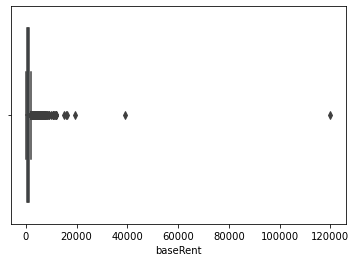

In [36]:
#Review distribution of prices for premium_rentals
_= sns.boxplot(x = 'baseRent', data = premium_rentals)

- We observe that premium units have a wide price range, suggesting the presence of errors. This means that there would be many missing records falling within this determined price range, thus disproving our hypothesis. We probably need to treat the price features first before inputting missing values for the interiorQual feature. We will leave features as-is for now. 

- 'typeOfFlat': Indicates the style of apartment. Previously determined top category as 'apartment' at 57% and about 13% of its values are missing.

In [37]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts()

apartment              130695
roof_storey             34618
ground_floor            31358
other                    9486
maisonette               9297
raised_ground_floor      5610
penthouse                3567
terraced_flat            3374
half_basement            2005
loft                      953
Name: typeOfFlat, dtype: int64

-  There is no discernable trend associated with these categories. We will leave this features as-is for now.

- 'energyEfficiencyClass': Indicates energy efficiency rating of building. Previously determined top category as C at 19% and 71% of it values are missing. Data owner indicated that information on this feature was not provided from February 2019. 

In [38]:
#Review count of energyEfficiencyClass categories
rentals.energyEfficiencyClass.value_counts()

C                 14544
NO_INFORMATION    14041
D                 13845
B                 11322
E                  7914
A                  4986
F                  4421
A_PLUS             3617
G                  1787
H                   884
Name: energyEfficiencyClass, dtype: int64

- Listed categories confirm research that ratings go from from A+ to H. There are two types of energy certificates that measure different things and there is no consensus on the preferred method. This may be the reason why information was not provided as from February 2019 and the reason there are many units without this information. We are unlikely to fill missing values and will drop this feature given the large number of missing values. 

In [39]:
#Drop identified features from rentals
rentals.drop(columns = ['houseNumber','streetPlain','description','facilities','firingTypes', 'energyEfficiencyClass'], axis = 1, inplace = True)


In [40]:
rentals.head(2)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,False,Nordrhein_Westfalen,True,2.0,595.0,86.0,Dortmund,well_kept,normal,no,Sch&uuml;ruferstra&szlig;e,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.0,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,False,Rheinland_Pfalz,False,1.0,800.0,89.0,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,NaN,2019.0,NaN,NaN,May19


## Reviewing Numerical Features with Missing Values

In [41]:
mssgNumeric.describe()

,serviceCharge,telekomHybridUploadSpeed,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,yearConstructedRange,thermalChar,floor,numberOfFloors,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,267018.000000,235492.000000,2.283330e+05,211805.000000,93052.000000,211805.000000,162344.000000,217541.000000,171118.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,3.389001,28.804928,9.013315e+02,1966.400590,1.327634,3.714544,114.749533,2.122405,3.572319,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,1.964874,16.337151,3.323833e+04,46.992207,8.361403,2.738134,61.653663,3.634934,6.375496,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,-12.330000,1.000000,0.000000e+00,1000.000000,0.000000,1.000000,0.100000,-1.000000,0.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,2.000000,10.000000,4.698000e+02,1950.000000,1.000000,1.000000,79.000000,1.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,3.390000,40.000000,6.500000e+02,1973.000000,1.000000,3.000000,107.000000,2.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,4.570000,40.000000,9.850000e+02,1996.000000,1.000000,5.000000,140.300000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,14.920000,100.000000,1.575154e+07,2090.000000,2241.000000,9.000000,1996.000000,999.000000,999.000000,12613.000000,2919.000000,90.760000,0.227600


In [42]:
rentals = rentals.loc[:,~(missing['%age total'] > 25)]

In [43]:
rentals.shape

(267474, 32)

## Reviewing objects

In [44]:
rentalsObj =rentals.select_dtypes('object')

In [45]:
rentalsObj.head()

,regio1,heatingType,telekomTvOffer,geo_bln,geo_krs,street,typeOfFlat,regio2,regio3,date
0,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,Nordrhein_Westfalen,Dortmund,Sch&uuml;ruferstra&szlig;e,ground_floor,Dortmund,Schüren,May19
1,Rheinland_Pfalz,self_contained_central_heating,ONE_YEAR_FREE,Rheinland_Pfalz,Rhein_Pfalz_Kreis,no_information,ground_floor,Rhein_Pfalz_Kreis,Böhl_Iggelheim,May19
2,Sachsen,floor_heating,ONE_YEAR_FREE,Sachsen,Dresden,Turnerweg,apartment,Dresden,Äußere_Neustadt_Antonstadt,Oct19
3,Sachsen,district_heating,ONE_YEAR_FREE,Sachsen,Mittelsachsen_Kreis,Gl&uuml;ck-Auf-Stra&szlig;e,other,Mittelsachsen_Kreis,Freiberg,May19
4,Bremen,self_contained_central_heating,NONE,Bremen,Bremen,Hermann-Henrich-Meier-Allee,apartment,Bremen,Neu_Schwachhausen,Feb20


In [46]:
rentalsObj.nunique()

regio1               16
heatingType          13
telekomTvOffer        2
geo_bln              16
geo_krs             419
street            52183
typeOfFlat           10
regio2              419
regio3             8668
date                  4
dtype: int64

In [47]:
#regio1 refers to the state in Germany. There are 16.

rentalsObj['regio1'].value_counts() 

Nordrhein_Westfalen       62244
Sachsen                   58013
Bayern                    21584
Sachsen_Anhalt            20005
Hessen                    17802
Niedersachsen             16489
Baden_Württemberg         16044
Berlin                    10334
Rheinland_Pfalz            8351
Thüringen                  8332
Brandenburg                6915
Schleswig_Holstein         6645
Mecklenburg_Vorpommern     6593
Hamburg                    3749
Bremen                     2949
Saarland                   1425
Name: regio1, dtype: int64

In [48]:
#telekomTvOffer refers to the option of cable service being included with the rent.There are 3 categories. 
rentalsObj['telekomTvOffer'].value_counts() 

ONE_YEAR_FREE    226415
NONE              41059
Name: telekomTvOffer, dtype: int64

The data owner noted that geo_bln and regio1 have the same values,as well as geo_krs and regio2.
We also observe this from their value counts that are identical. We will confirm this and eliminate redundant features.


In [49]:
#There are no values that are different between regio1 and geo_bln. 
#We will drop geo_bln
(rentalsObj["regio1"] != rentalsObj['geo_bln']).sum() 

0

In [50]:
#There are no values that are different between regio2 and geo_krs. 
#We will drop geo_krs
(rentalsObj["regio2"] != rentalsObj["geo_krs"]).sum()

0

In [51]:
#typeOfFlat gives information on the kind of apartment it is. It has 10 categories.
rentalsObj['typeOfFlat'].value_counts()

apartment              130695
roof_storey             34618
ground_floor            31358
other                    9486
maisonette               9297
raised_ground_floor      5610
penthouse                3567
terraced_flat            3374
half_basement            2005
loft                      953
Name: typeOfFlat, dtype: int64

In [52]:
#regio3 refers to the city or town of the apartment
#There are over 8600 towns in the dataframe suggesting a high amount of cardinality.

rentalsObj['regio3'].value_counts().head()

Innenstadt    4731
Stadtmitte    2686
Altstadt      2325
Sonnenberg    1909
Kaßberg       1709
Name: regio3, dtype: int64

In [53]:
#date provides information on when (four dates) the posting was scraped from the web. 
#The date does not add value to the analysis. We will drop the column
rentalsObj['date'].value_counts()

Feb20    78913
May19    75660
Oct19    66344
Sep18    46557
Name: date, dtype: int64

In [54]:
#Droping columns
rentals.drop(columns = ['geo_bln','geo_krs','street', 'date'], inplace = True)

In [55]:
rentals.shape[1]

28

## Reviewing Numeric Features 

In [56]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

rentalsNum= rentals.select_dtypes(include=numerics)

In [57]:
rentalsNum.head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,floor,noRoomsRange,livingSpaceRange
0,245.00,6,4.62,10.0,840.0,1965.0,96107057,2.0,595.0,86.00,4,44269,4.0,1.0,4,4
1,134.00,8,3.47,10.0,NaN,1871.0,111378734,1.0,800.0,89.00,5,67459,3.0,NaN,3,4
2,255.00,8,2.72,2.4,1300.0,2019.0,113147523,9.0,965.0,83.80,6,1097,3.0,3.0,3,4
3,58.15,9,1.53,40.0,NaN,1964.0,108890903,2.0,343.0,58.15,2,9599,3.0,3.0,3,2
4,138.00,19,2.46,NaN,903.0,1950.0,114751222,1.0,765.0,84.97,5,28213,3.0,1.0,3,4


In [58]:
rentalsNum.describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,260585.0,1.512844e+02,3.090510e+02,0.00,9.500000e+01,1.350000e+02,1.900000e+02,1.461180e+05
picturecount,267474.0,9.800033e+00,6.411112e+00,0.00,6.000000e+00,9.000000e+00,1.300000e+01,1.210000e+02
pricetrend,265647.0,3.390478e+00,1.965370e+00,-12.33,2.000000e+00,3.390000e+00,4.580000e+00,1.492000e+01
telekomUploadSpeed,234211.0,2.880628e+01,1.633706e+01,1.00,1.000000e+01,4.000000e+01,4.000000e+01,1.000000e+02
totalRent,227190.0,9.028076e+02,3.332183e+04,0.00,4.700000e+02,6.500000e+02,9.860000e+02,1.575154e+07
yearConstructed,210735.0,1.966460e+03,4.705110e+01,1000.00,1.950000e+03,1.973000e+03,1.996000e+03,2.090000e+03
scoutId,267474.0,1.069625e+08,1.251358e+07,28871743.00,1.066852e+08,1.111584e+08,1.137689e+08,1.157117e+08
yearConstructedRange,210735.0,3.721494e+00,2.741756e+00,1.00,1.000000e+00,3.000000e+00,5.000000e+00,9.000000e+00
baseRent,267474.0,6.949672e+02,1.958483e+04,0.00,3.383600e+02,4.900000e+02,8.000000e+02,9.999999e+06
livingSpace,267474.0,7.437064e+01,2.554058e+02,0.00,5.400000e+01,6.734000e+01,8.700000e+01,1.111110e+05


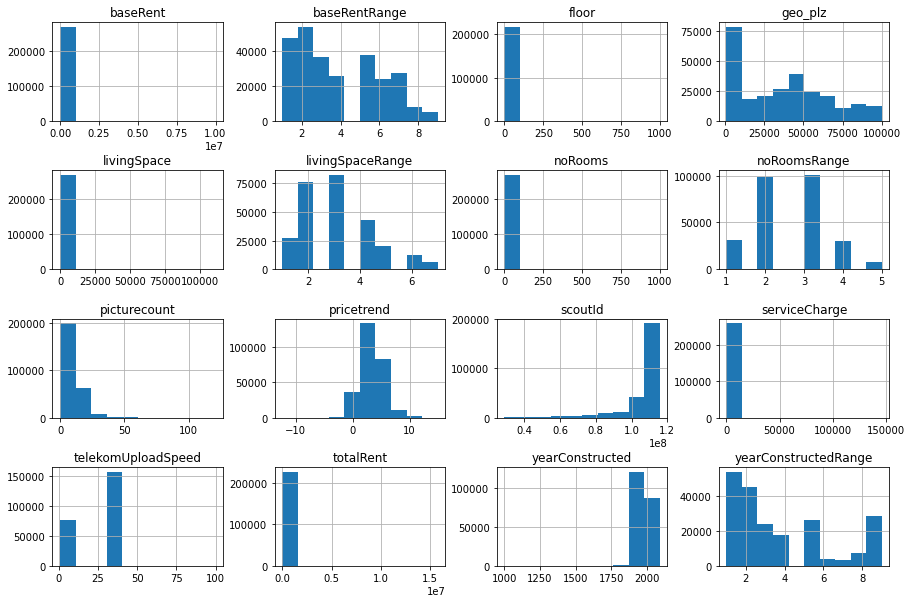

In [59]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)


We note the following information from the data owner:
- scoutId is an identifier for each rental listing. It has no relevance for analysis. This will be dropped.
- pricetrend is metric determined by the data owner. There is no visibility to what this means. This will be dropped.
- geo_plz should be an object because it is the zip code of each property
- noRoomsRange is the histogram bin number corresponding to the noRooms. This is additional information we do not need. This will be dropped.
- livngSpaceRange is the historgram bin number corresponding to livingSpace. This is additional information we do not need. This will be dropped.
- baseRentRange is the historgram bin number corresponding to baseRent. This is additional information we do not need. This will be dropped.

In [60]:
rentalsNum.drop(columns = ['pricetrend','geo_plz','scoutId','noRoomsRange', 'livingSpaceRange', 'baseRentRange'], inplace = True)

C:\Users\zebin\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


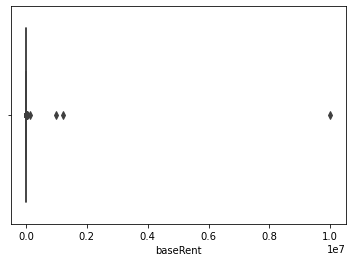

In [61]:
_= sns.boxplot(x = 'baseRent', data = rentalsNum)
#We observe high monthly rent rates, going to 10bln euros. For now, we will restrict max rent to 50,000 euros
# and min rent to 50 euros

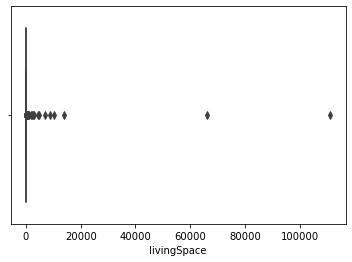

In [62]:
_= sns.boxplot(x = 'livingSpace', data = rentalsNum)  
#We observe units with large sizes. We will restrict the max unit area to 1000 sqm and min area to 10 sqm (parking lot). 

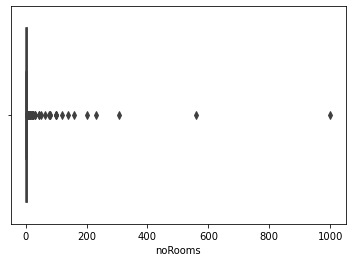

In [63]:
_= sns.boxplot(x = 'noRooms', data = rentalsNum)
#We observe units with many rooms. For now, we will restrict max number of rooms to 100 and min number of rooms to 1. 

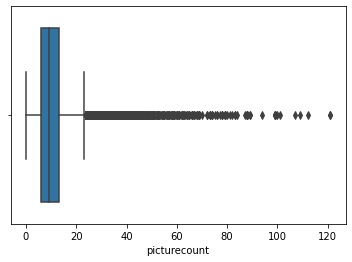

In [64]:
_= sns.boxplot(x = 'picturecount', data = rentalsNum)
#We will restrict number of pictures to 50

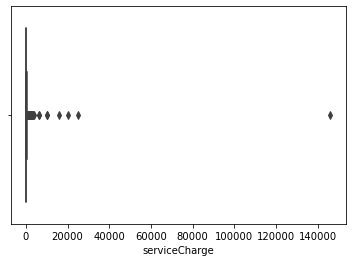

In [65]:
_= sns.boxplot(x = 'serviceCharge', data = rentalsNum)
#For now,we will restrict max serviceCharge to 10,000 euros

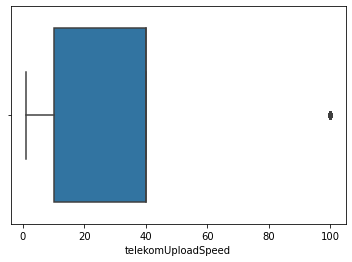

In [66]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentalsNum)

In [67]:
#Adding the restrictions 
rent = (rentalsNum.baseRent > 50) & (rentalsNum.baseRent < 4000)
space = (rentalsNum.livingSpace > 10) & (rentalsNum.livingSpace < 300)
rooms = (rentalsNum.noRooms > 1) & (rentalsNum.noRooms < 10)
pictures = (rentalsNum.picturecount < 50)
charge = (rentalsNum.serviceCharge < 1000)
selectRows = rent & space & rooms & pictures & charge

In [68]:
#Including only select rows in our numeric dataframe
rentalsNum = rentalsNum[selectRows]

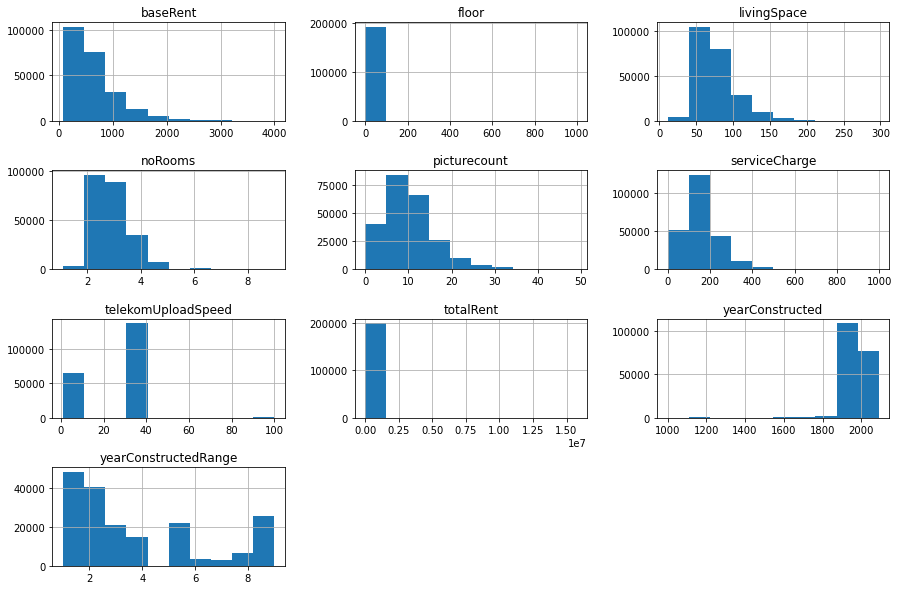

In [69]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)

In [70]:
#Including only select rows in our main dataframe
rentals = rentals[selectRows]

In [71]:
#Dropping aforementioned columns
rentals.drop(columns = ['pricetrend','scoutId','noRoomsRange','livingSpaceRange', 'baseRentRange'], inplace = True)

In [72]:
#Converting geo_plz to string
rentals['geo_plz'] = rentals['geo_plz'].astype(str)

In [73]:
rentals.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 232898 entries, 0 to 268849
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   regio1                232898 non-null  object 
 1   serviceCharge         232898 non-null  float64
 2   heatingType           196646 non-null  object 
 3   telekomTvOffer        232898 non-null  object 
 4   newlyConst            232898 non-null  bool   
 5   balcony               232898 non-null  bool   
 6   picturecount          232898 non-null  int64  
 7   telekomUploadSpeed    204402 non-null  float64
 8   totalRent             199047 non-null  float64
 9   yearConstructed       186188 non-null  float64
 10  hasKitchen            232898 non-null  bool   
 11  cellar                232898 non-null  bool   
 12  yearConstructedRange  186188 non-null  float64
 13  baseRent              232898 non-null  float64
 14  livingSpace           232898 non-null  float64
 15  

In [74]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,telekomUploadSpeed,totalRent,yearConstructed,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,lift,typeOfFlat,geo_plz,noRooms,floor,garden,regio2,regio3
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,6,10.0,840.0,1965.0,False,True,2.0,595.0,86.00,False,ground_floor,44269,4.0,1.0,True,Dortmund,Schüren
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,False,True,8,10.0,NaN,1871.0,False,False,1.0,800.0,89.00,False,ground_floor,67459,3.0,NaN,False,Rhein_Pfalz_Kreis,Böhl_Iggelheim
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,8,2.4,1300.0,2019.0,False,True,9.0,965.0,83.80,True,apartment,1097,3.0,3.0,False,Dresden,Äußere_Neustadt_Antonstadt
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,9,40.0,NaN,1964.0,False,False,2.0,343.0,58.15,False,other,9599,3.0,3.0,False,Mittelsachsen_Kreis,Freiberg
4,Bremen,138.00,self_contained_central_heating,NONE,False,True,19,NaN,903.0,1950.0,False,False,1.0,765.0,84.97,False,apartment,28213,3.0,1.0,False,Bremen,Neu_Schwachhausen


In [75]:
datapath = 'C:\\Users\\zebin\\OneDrive\\Documents\\Education\\Data Science\\Springboard - Data Science\\Capstones\\Capstone_2\\german_apartment_rentals\\data\\processed'
# renaming the output data directory and re-running this notebook, for example,
# will recreate this (empty) directory and resave the data files.
# NB this is not a substitute for a modern data pipeline, for which there are
# various tools. However, for our purposes here, and often in a "one off" analysis,
# this is useful because we have to deliberately move/delete our data in order
# to overwrite it.
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [76]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)